### Install required packages

In [1]:
#try: # Install microgrids package in JupyterLite (if run in JupyterLite)
#    import piplite
#    await piplite.install([ 'ipywidgets', ])
#except ImportError:
#    pass

### Import required packages

In [2]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import VBox, interactive_output, Output

### Load and renewable generation is taken from village Palari in Chhattisgarh (cite: Paper)

### Functions to calculate the generation from different sources

In [3]:
# Daily load is taken out from the paper
load_profile = [18, 5, 5, 5, 5, 1, 7, 3, 4, 22, 24, 25, 26, 27, 28, 27, 23, 21, 32, 27, 34, 24, 25, 20]

# Solar generation for the day, assuming Sine wave distribution
def solar_generation(peak_solar, nos_sunlight_hours):

    # Solar as shown in the paper is a half sinusoidal function between 6am to 6pm
    # Generate 12 points between 0 and pi (half of the sine wave)
    x = np.linspace(0, np.pi, nos_sunlight_hours)

    # Apply the sine function to get a half-sinusoidal distribution
    sinusoidal_values = np.sin(x)

    # Normalize the values to a specific range if needed (optional)
    # For example, scaling between 0 and 1
    normalized_values = sinusoidal_values / np.max(sinusoidal_values)

    # Peak Solar power is taken as 20KW
    solar_generation = np.round(normalized_values,2) * peak_solar

    # Add the dark hours
    # Hours before dawn
    dawn = int((24 - nos_sunlight_hours)/2)
    # Hours after dusk
    dusk = 24 - (nos_sunlight_hours + dawn)

    # Generation array for full day
    solar = np.concatenate((np.zeros(dawn), solar_generation, np.zeros(dusk)))

    return solar

# Wind generation for the day, assuming it to be a random distribution
def wind_generation(minm_generation, maxm_generation):

    # Set a fixed seed for reproducibility
    random.seed(42)

    # Wind energy is also from the paper as an random function
    wind_list = [random.randint(minm_generation,maxm_generation) for _ in range(24)]
    
    return np.array(wind_list)

# Nuclear Generation for the day. It is assumed that it has load following features
def nuke_generation(nuke_rated, range):

    minm_generation = nuke_rated * (1 - range)
    
    return (minm_generation, nuke_rated)

# Grid storage i.e Battery characteristics
def battery_storage(cap, soc, chg_rate, dsc_rate):

    # Total battery capacity
    battery_capacity = cap
    # Initial state of charge
    battery_soc = cap * soc
    # The maximum allowed charge rate
    battery_max_charge_rate = cap * chg_rate
    # The maximum allowed discharge rate
    battery_max_discharge_rate = cap * dsc_rate
    
    return (battery_capacity, battery_soc, battery_max_charge_rate, battery_max_discharge_rate)


### Solar & Wind generation and MMR & Battery rating

In [4]:
# Daily Solar Energy
solar = solar_generation(20, 12)
# Daily Wind Energy
wind = wind_generation(0, 15)
MMR = 8
MMR_range = 0.5
battery_capacity = 80
battery_soc =  0.35
battery_max_charge_rate = 0.25
battery_max_discharge_rate = 0.25

In [5]:
print(f'Hourly Load: {load_profile}')
print(f'Hourly wind generation: {wind}')
print(f'Hourly solar generation: {np.round(solar,2)}')

Hourly Load: [18, 5, 5, 5, 5, 1, 7, 3, 4, 22, 24, 25, 26, 27, 28, 27, 23, 21, 32, 27, 34, 24, 25, 20]
Hourly wind generation: [ 3  0  8  7  7  4  3  2 13  1  0  2  6  7  0  6 13  7 14  8  0  5 13 10]
Hourly solar generation: [ 0.   0.   0.   0.   0.   0.   0.   5.6 11.  15.2 18.4 20.  20.  18.4
 15.2 11.   5.6  0.   0.   0.   0.   0.   0.   0. ]


### 

#### The goal is to simulate the power balance in a microgrid with solar, wind, nuclear, and battery storage based on a given load profile.
#### Steps:
#### 1. Adjust nuclear power to minimize excess energy when renewable generation exceeds load + battery charging capacity.
#### 2. Track battery SOC (state of charge) throughout the day.
#### 3. Ensure load is served by a combination of renewables, nuclear, and battery power.


In [6]:
def load_match(load_profile, solar, wind, nuclear, battery):

    # Initialise list to store results
    nuclear_power_output = []
    battery_soc_history = []
    excess_energy_history = []
    deficit_history = []

    # Get the variables from array
    nuclear_min, nuclear_max = nuclear
    battery_capacity, battery_soc, battery_max_charge_rate, battery_max_discharge_rate = battery

    # Total of wind + solar
    renewable_generation = [a+round(b,1) for (a,b) in zip(wind,solar)]

    # Do hourly analysis for a typical day
    for hour in range(24):
        # Calculate the initial required nuclear power assuming no excess. 
        # 1. Calculate minimum requirement of deficit and maximum nuke power
        # 2. If it's less than nuke minimum, then choose nuke minimum
        nuclear_power = max(nuclear_min, min(nuclear_max, load_profile[hour] - renewable_generation[hour]))
    
        # Check the total available generation (renewable + nuclear)
        total_generation = renewable_generation[hour] + nuclear_power
    
        # If generation exceeds load and battery charging, adjust nuclear to minimize excess
        excess_energy = total_generation - load_profile[hour]
        #print(excess_energy)

        # Excess energy to be used for battery charging
        if excess_energy > 0:
            # Calculate the amount of energy that can be stored in the battery
            available_battery_capacity = battery_capacity - battery_soc
            # We can charge the battery only to the maximum charging rate
            charge_to_battery = min(excess_energy, available_battery_capacity, battery_max_charge_rate)
            battery_soc += charge_to_battery
            excess_energy -= charge_to_battery
            
        # If generation is less than the load, discharge battery if possible
        elif total_generation < load_profile[hour]:
            deficit_energy = load_profile[hour] - total_generation
            # Limit the discharge to maximum discharge rate of battery
            discharge_from_battery = min(deficit_energy, battery_soc, battery_max_discharge_rate)
            battery_soc -= discharge_from_battery
            deficit_energy -= discharge_from_battery
            # Generation could not match the load
            if deficit_energy > 0:
                deficit_history.append([hour,-deficit_energy / load_profile[hour]])
            else:
                excess_energy = 0

        # Store the results for each hour
        nuclear_power_output.append(round(nuclear_power,1))
        battery_soc_history.append(round(battery_soc,1))
        excess_energy_history.append(round(excess_energy,1))
        deficit_hours = excess_energy_history.count(-1)
        wasted_energy = [a if a>0 else 0 for a in excess_energy_history]

    # Convert results to numpy arrays for easier analysis
    nuclear_power_output = np.array(nuclear_power_output)
    battery_soc_history = np.array(battery_soc_history)
    excess_energy_history = np.array(excess_energy_history)
    
    #print(f'Deficit hours and the deficit percent were: {deficit_history}')
    
    return (nuclear_power_output, battery_soc_history, excess_energy_history)

In [7]:
nuclear_power_output, battery_soc_history, excess_energy_history = load_match(
    load_profile, 
    solar, 
    wind, 
    nuke_generation(MMR, MMR_range), 
    battery_storage(battery_capacity, battery_soc, battery_max_charge_rate, battery_max_discharge_rate)
)

print(f'Nuclear Power Generated: {nuclear_power_output}')
print(f'Battery State of Charge: {battery_soc_history}')
print(f'Excess charge history: {excess_energy_history}')


Nuclear Power Generated: [8.  5.  4.  4.  4.  4.  4.  4.  4.  5.8 5.6 4.  4.  4.  8.  8.  4.4 8.
 8.  8.  8.  8.  8.  8. ]
Battery State of Charge: [21.  21.  28.  34.  40.  47.  47.  55.6 75.6 75.6 75.6 76.6 80.  80.
 75.2 73.2 73.2 67.2 57.2 46.2 26.2 15.2 11.2  9.2]
Excess charge history: [  0.    0.    0.    0.    0.    0.    0.    0.    4.    0.    0.    0.
   0.6   2.4   0.    0.    0.    0.    0.    0.  -26.    0.    0.    0. ]


### Plot the Microgrid Components vs the Load demand

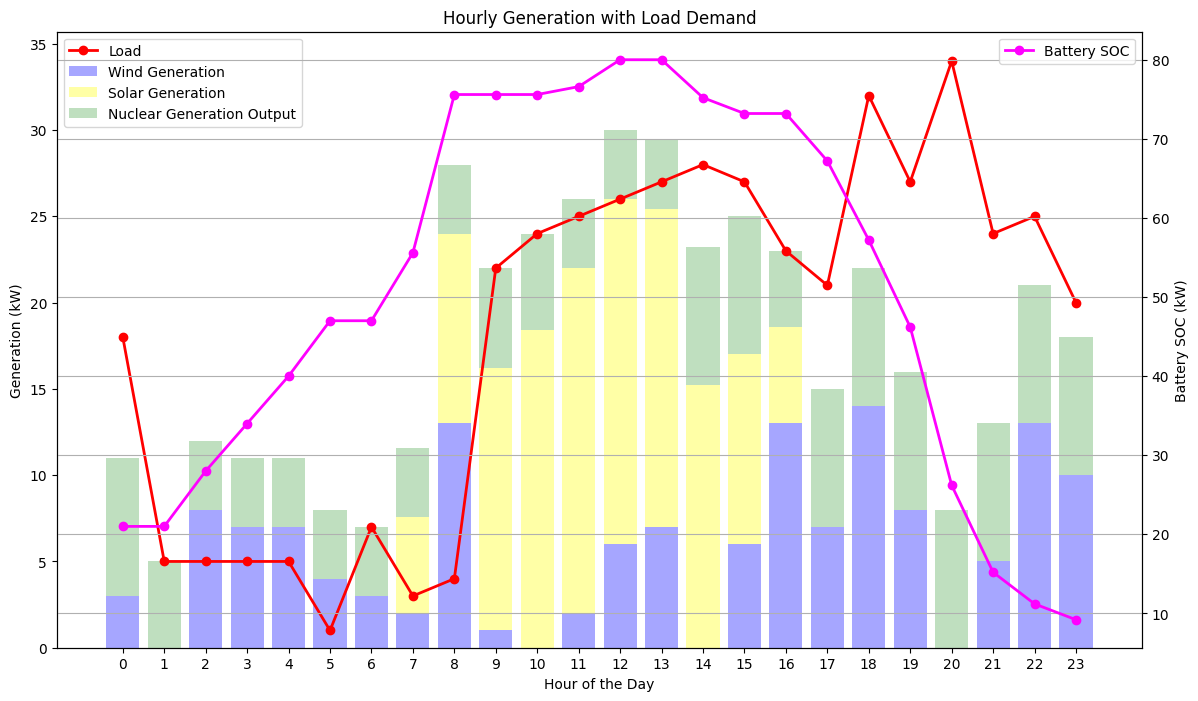

In [8]:
# Hours of the day
hours = [i for i in range(len(load_profile))]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(14, 8))  # Set figure size to 14x8 inches

# Plot stacked bar chart for wind and solar generation
ax1.bar(hours, wind, label='Wind Generation', color='blue', alpha=0.35)
ax1.bar(hours, solar, bottom=wind, label='Solar Generation', color='yellow', alpha=0.35)
ax1.bar(hours, nuclear_power_output, bottom=wind + solar, label='Nuclear Generation Output', color='green', alpha=0.25)
ax1.plot(hours, load_profile, color='red', label='Load', linewidth=2, marker='o')

# Set x-axis to represent hours of the day
ax1.set_xticks(hours)
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Generation (kW)')

# Create a second y-axis to plot the load as a line
ax2 = ax1.twinx()
ax2.plot(hours, battery_soc_history, label='Battery SOC', color='magenta', linewidth=2, marker='o')
ax2.set_ylabel('Battery SOC (kW)')

# Excess Power
#ax3 = ax1.twinx()

#ax3.spines['right'].set_position(('outward', 60))  # Move third axis 60 pixels away from the second
#ax3.plot(hours, excess_energy_history, label='Excess Power', color='yellow', linewidth=2, marker='x')
#ax3.set_ylabel('Excess Energy (kW)')

plt.plot()

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
#ax3.legend(loc='upper center')

# Add a title and show the plot
plt.title('Hourly Generation with Load Demand')
plt.grid(True)
plt.show()

### Plot the line graphs for the Excess Generation Cause and effect

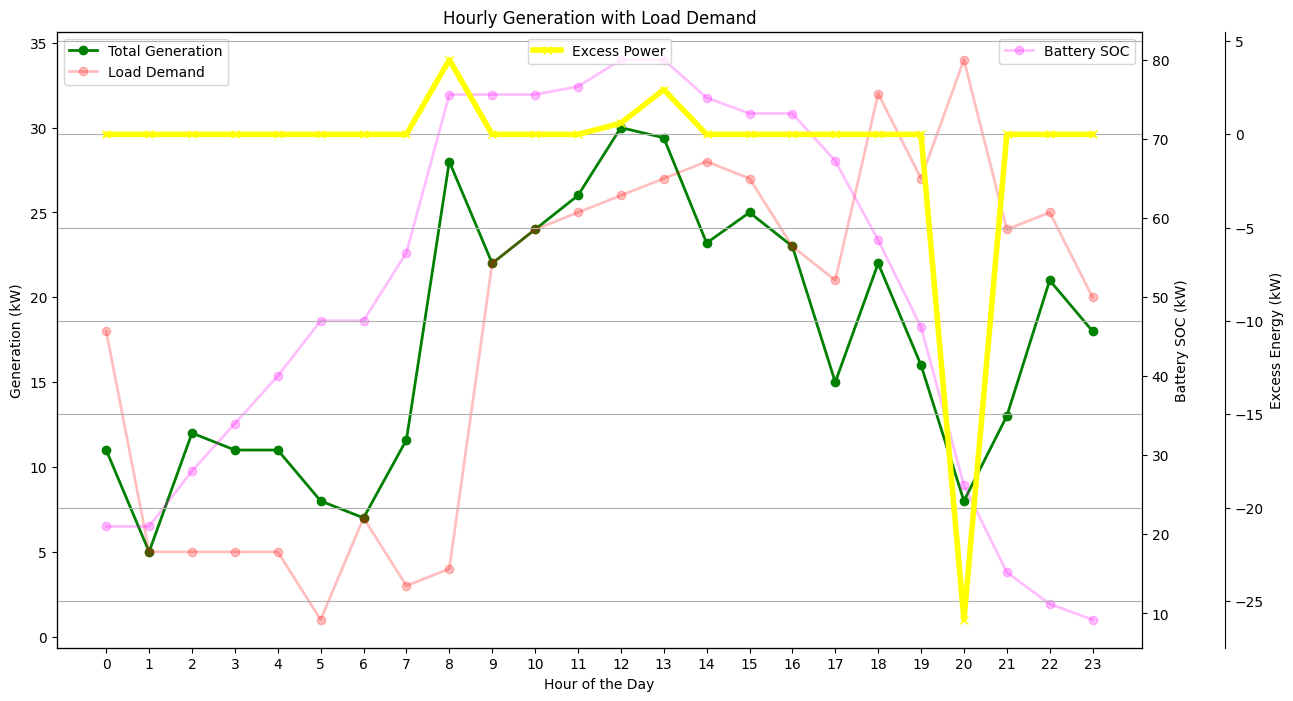

In [9]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(14, 8))  # Set figure size to 14x8 inches

total_generation = wind + solar + nuclear_power_output

# Plot stacked bar chart for wind and solar generation
#ax1.bar(hours, wind, label='Wind Generation', color='blue')
#ax1.bar(hours, solar, bottom=wind, label='Solar Generation', color='purple')
#ax1.bar(hours, nuclear_power_output, bottom=wind + solar, label='Nuclear Generation Output', color='green')
ax1.plot(hours, total_generation, color='green', label='Total Generation', linewidth=2, marker='o')
ax1.plot(hours, load_profile, color='red', label='Load Demand', linewidth=2, alpha=0.25, marker='o')

# Set x-axis to represent hours of the day
ax1.set_xticks(hours)
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Generation (kW)')

# Create a second y-axis to plot the load as a line
ax2 = ax1.twinx()
ax2.plot(hours, battery_soc_history, label='Battery SOC', color='magenta', alpha=0.25, linewidth=2, marker='o')
ax2.set_ylabel('Battery SOC (kW)')

# Excess Power
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Move third axis 60 pixels away from the second
ax3.plot(hours, excess_energy_history, label='Excess Power', color='yellow', linewidth=4, marker='x')
ax3.set_ylabel('Excess Energy (kW)')

plt.plot()

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='upper center')

# Add a title and show the plot
plt.title('Hourly Generation with Load Demand')
plt.grid(True)
plt.show()

### Interactive Plot to observe cause - effect

In [10]:
def plot_metrics(mmr_range):

    nuclear = nuke_generation(MMR, mmr_range)
    battery = battery_storage(battery_capacity, battery_soc, battery_max_charge_rate, battery_max_discharge_rate)
    #print(nuclear)

    nuclear_power_output, battery_soc_history, excess_energy_history = load_match(
        load_profile, 
        solar, 
        wind, 
        nuclear, 
        battery
    )
#    print(f'Nuclear Power Generated: {nuclear_power_output}')
#    print(f'Battery State of Charge: {battery_soc_history}')
#    print(f'Excess charge history: {excess_energy_history}')
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot Nuclear generation for the day
    ax1.set_xticks(hours)
    ax1.set_xlabel('Hour of the Day')
    ax1.set_ylabel('Generation (kW)')
    ax1.plot(hours, nuclear_power_output, color='orange', label='Nuclear Generation', linewidth=4, alpha=0.5, marker='o')

    # Plot Battery State of Charge for the day
    ax2 = ax1.twinx()
    ax2.plot(hours, battery_soc_history, label='Battery SOC', color='green', alpha=0.5, linewidth=4, marker='o')
    ax2.set_ylabel('Battery SOC (kW)')

    # Plot Excess Energy for the day
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Move third axis 60 pixels away from the second
    ax3.plot(hours, excess_energy_history, label='Excess Power', color='magenta', linewidth=4, marker='x')
    ax3.set_ylabel('Excess Energy (kW)')

    # Add legends for both axes
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax3.legend(loc='upper center')

    # Set limits on Y axis to observe effects better
    ax1.set_ylim(-1, 10)
    ax2.set_ylim(-10, 110)
    ax3.set_ylim(-30, 30)

    # Add a title and show the plot
    plt.title('Hourly Generation with Load Demand')

    return fig

### Define the slider widget

In [11]:
def update(mmr_range):
    """
    Update the output plot based on the slider values.
    """
    out1.clear_output(wait=True)
    with out1:
        fig1 = plot_metrics(mmr_range)
        plt.show(fig1)

In [12]:
# Widgets for interactive plots
mmr_range_slider = widgets.FloatSlider(value=1, min=0, max=1, step=0.05, description='MMR Load Following')

# Output widget for plots
out1 = Output()

# Interactive display
ui = VBox([mmr_range_slider])
interactive_plot = interactive_output(update, {'mmr_range': mmr_range_slider})

### Display in Box

In [13]:
display(VBox([ui, out1, interactive_plot]))